# Obesity Prediction with Random Forest Classifier

## 1. Import all the libraries required

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import  OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  
import shap
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load dataset and mapping the target

In [18]:
obesity = pd.read_csv("../data/raw/ObesityDataSet_raw_and_data_sinthetic.csv")

In [19]:
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [20]:
obesity.info()
#no null values so don't need to impute missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [21]:
# Encode target variable
label_encoder = LabelEncoder()
obesity['Target'] = label_encoder.fit_transform(obesity['NObeyesdad'])
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Target
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,1
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,1
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,5
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,6


## 3. Divide dataset into numerical and categorical

In [22]:
X = obesity.drop(columns=["Target","NObeyesdad"])
y = obesity["Target"]

# Divide features by type
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

## 5. Train test and split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
) 

## 6. Create the preprocessing pipeline

In [24]:
# numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num',  'passthrough', num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

## 7. Define random forest classifier and combine it with the preprocessing pipeline

In [25]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

## 8. Hyperparameter tunning 

In [26]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    "classifier__class_weight": [None, "balanced", "balanced_subsample"]
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


## 9. Evaluate the best model


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        54
           1       0.75      0.90      0.82        58
           2       0.94      0.96      0.95        70
           3       1.00      0.98      0.99        60
           4       1.00      0.98      0.99        65
           5       0.89      0.84      0.87        58
           6       0.96      0.91      0.94        58

    accuracy                           0.93       423
   macro avg       0.94      0.93      0.93       423
weighted avg       0.94      0.93      0.93       423

Accuracy: 0.9314420803782506


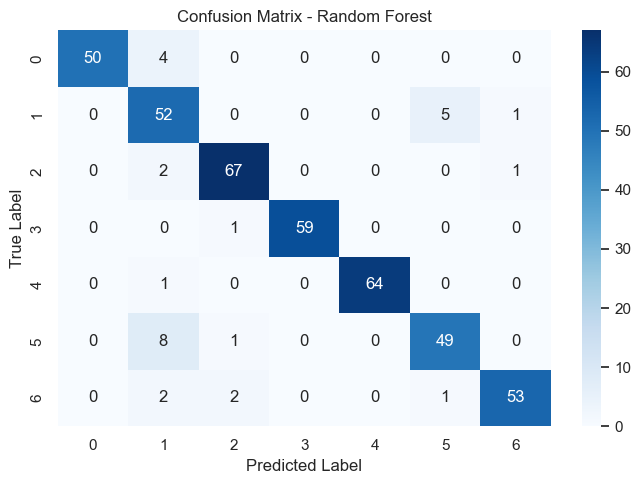

In [27]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Optional: Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("../images/random_forest_confusion_matrix_publication.png", dpi=300, bbox_inches="tight")
plt.show()

## 10. Plot the ROC and AUC curve

In [28]:
# ----------------------------------------------
# Prepare one-vs-rest setup
# ----------------------------------------------
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Get prediction probabilities
y_score = best_model.predict_proba(X_test)

# ----------------------------------------------
# Compute ROC curve and AUC for each class
# ----------------------------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

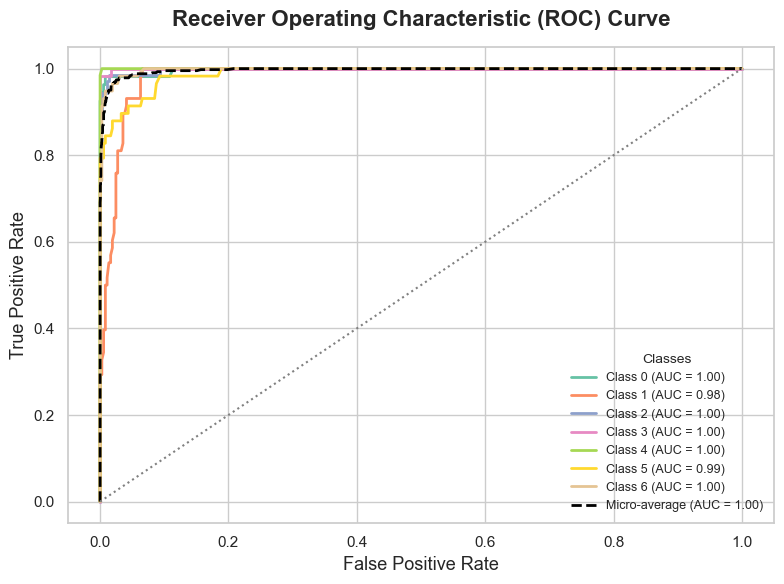

In [29]:
plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")

colors = sns.color_palette("Set2", n_colors=n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i],
        color=color,
        lw=2,
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})"
    )

# Micro-average line
plt.plot(
    fpr["micro"], tpr["micro"],
    color="black", linestyle="--",
    label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", lw=2
)

# Diagonal reference
plt.plot([0, 1], [0, 1], color="gray", lw=1.5, linestyle=":")

# Titles and labels
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(title="Classes", fontsize=9, title_fontsize=10, loc="lower right", frameon=False)
plt.tight_layout()

# Save publication-grade version
plt.savefig("../images/random_forest_roc_auc_publication.png", dpi=300, bbox_inches="tight")
plt.show()

## 11. SHapley Additive Explanations (SHAP)

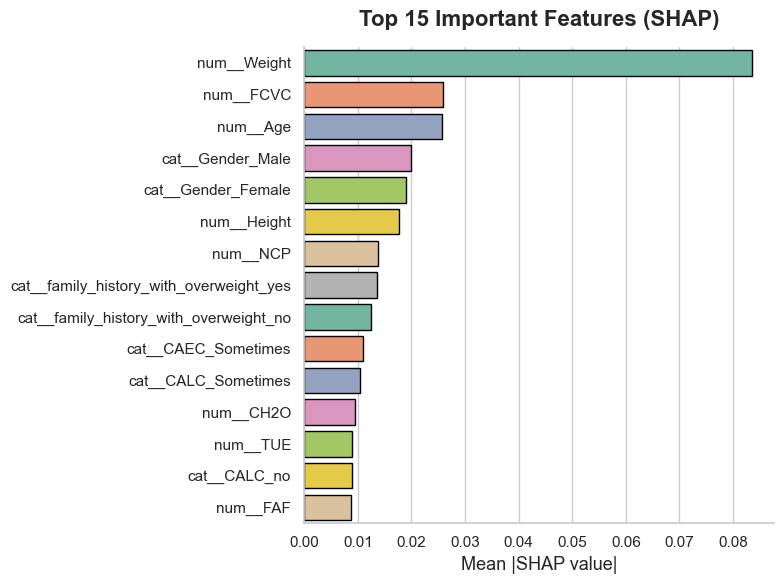

In [30]:
# SHAP feature importance
rf_model = best_model.named_steps["classifier"]
preprocessor = best_model.named_steps["preprocessor"]
X_preprocessed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Compute SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_preprocessed)

# Handle multi-class (list of arrays)
if isinstance(shap_values, list):
    # Average absolute SHAP values across classes - (n_samples, n_features)
    shap_values_mean_per_sample = np.mean([np.abs(sv) for sv in shap_values], axis=0)
else:
    shap_values_mean_per_sample = np.abs(shap_values)

# Take absolute values and average across samples and classes
mean_importance = np.mean(np.abs(shap_values), axis=(0, 2))  # (31,)

# Create summary DataFrame
shap_summary = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": mean_importance
    })
    .sort_values("Importance", ascending=False)
)

# Plot publication grade SHAP summary
plt.figure(figsize=(8, 6))
sns.barplot(
    data=shap_summary.head(15),
    hue="Feature",  
    y="Feature", x="Importance",
    legend=False, 
    palette="Set2", edgecolor="black"
)
plt.title("Top 15 Important Features (SHAP)", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Mean |SHAP value|", fontsize=13)
plt.ylabel("")
sns.despine()
plt.tight_layout()
# Save publication-grade version
plt.savefig("../images/random_forest_shap_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

Plotting SHAP for class 0: Insufficient_Weight


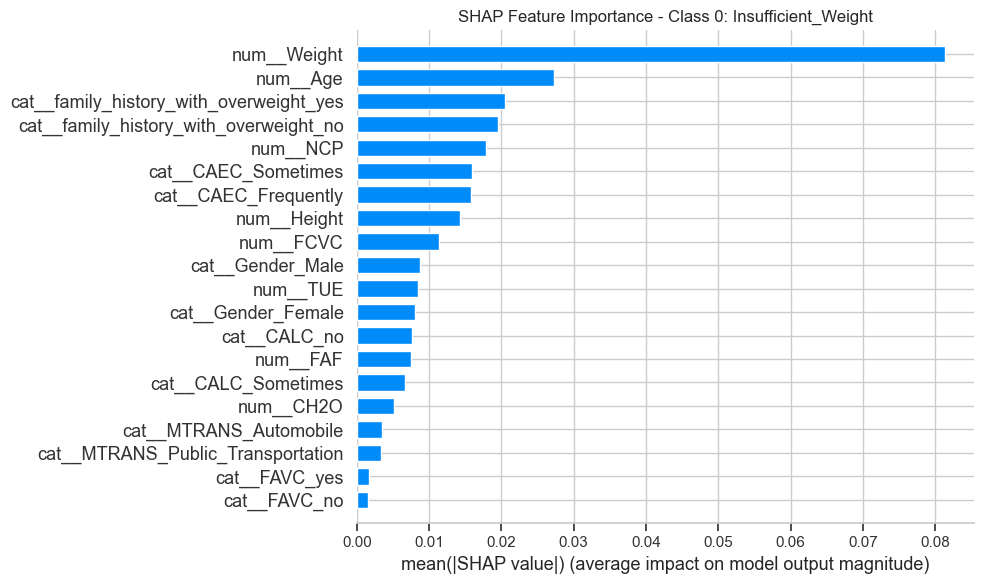

Plotting SHAP for class 1: Normal_Weight


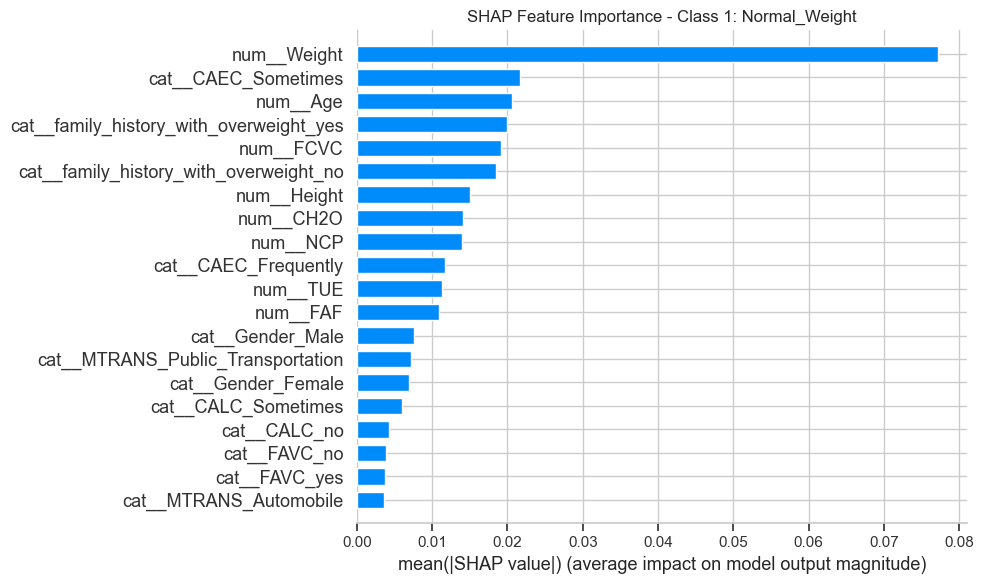

Plotting SHAP for class 2: Obesity_Type_I


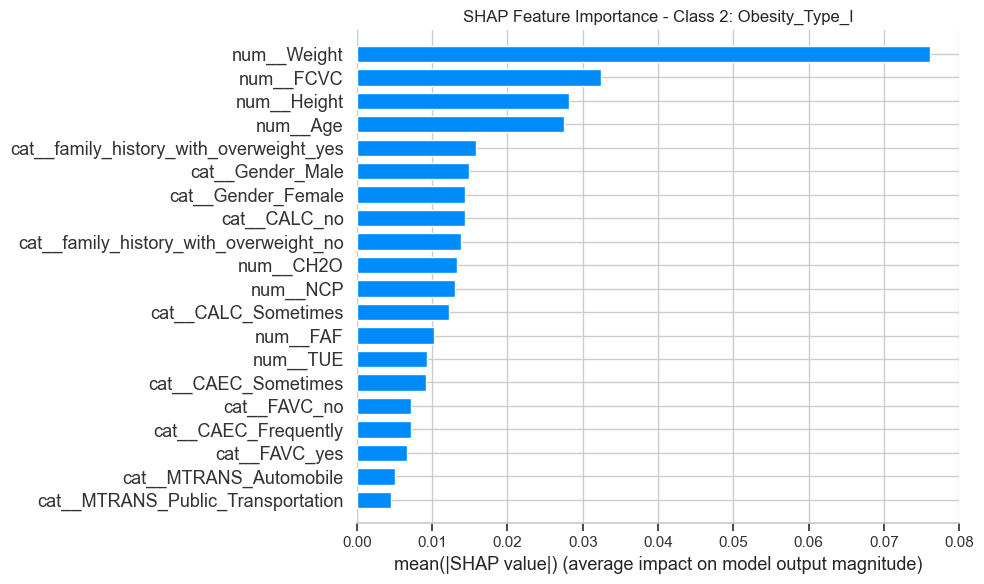

Plotting SHAP for class 3: Obesity_Type_II


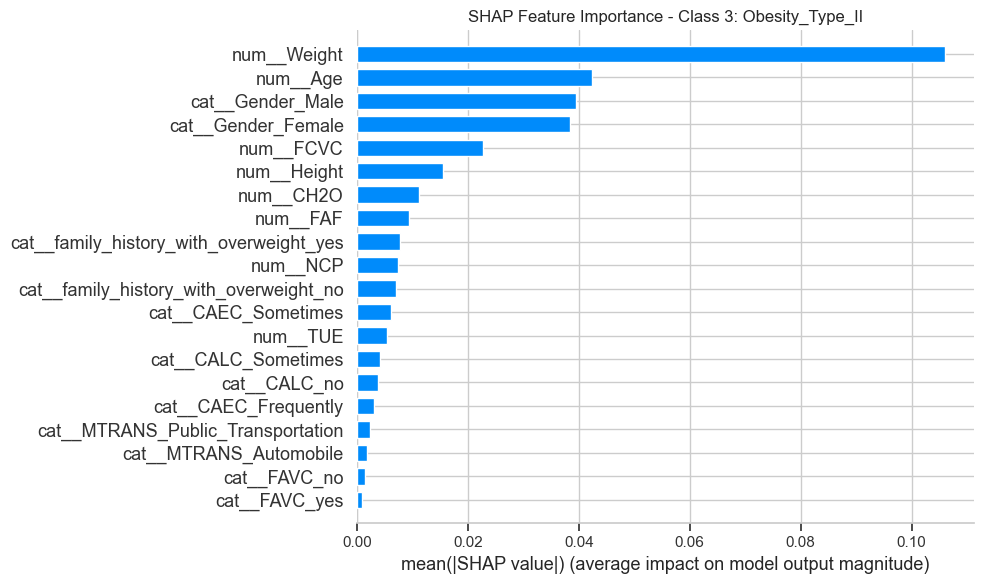

Plotting SHAP for class 4: Obesity_Type_III


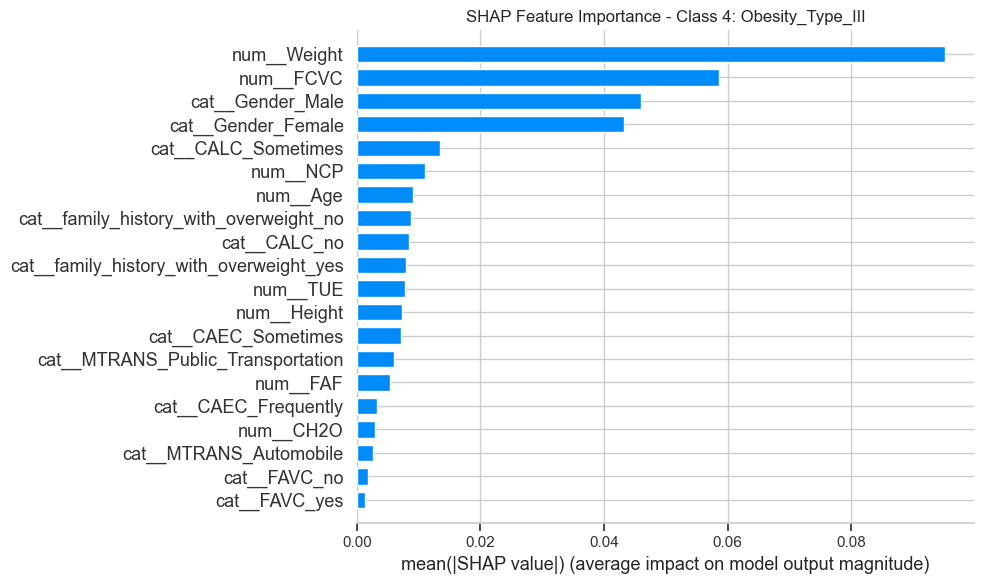

Plotting SHAP for class 5: Overweight_Level_I


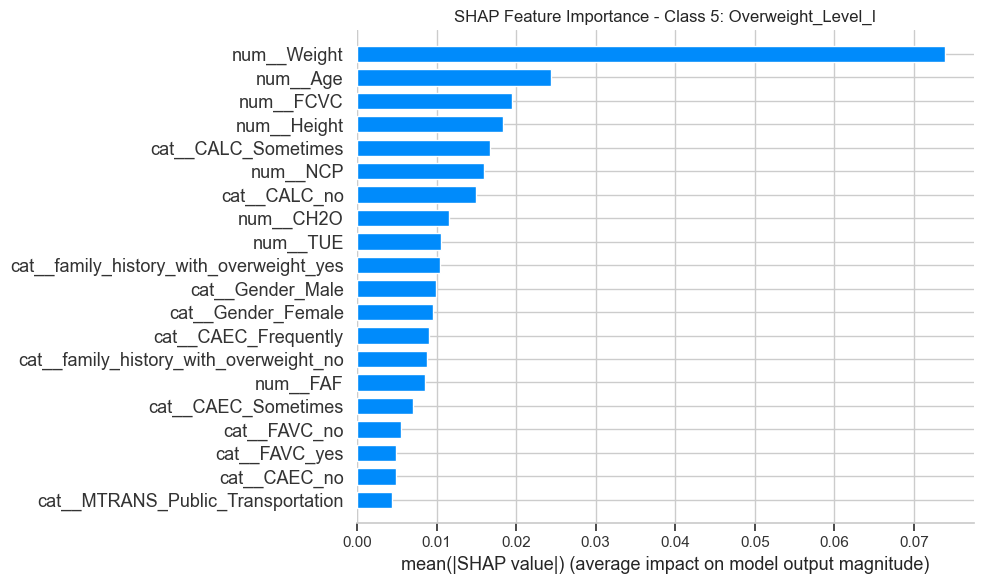

Plotting SHAP for class 6: Overweight_Level_II


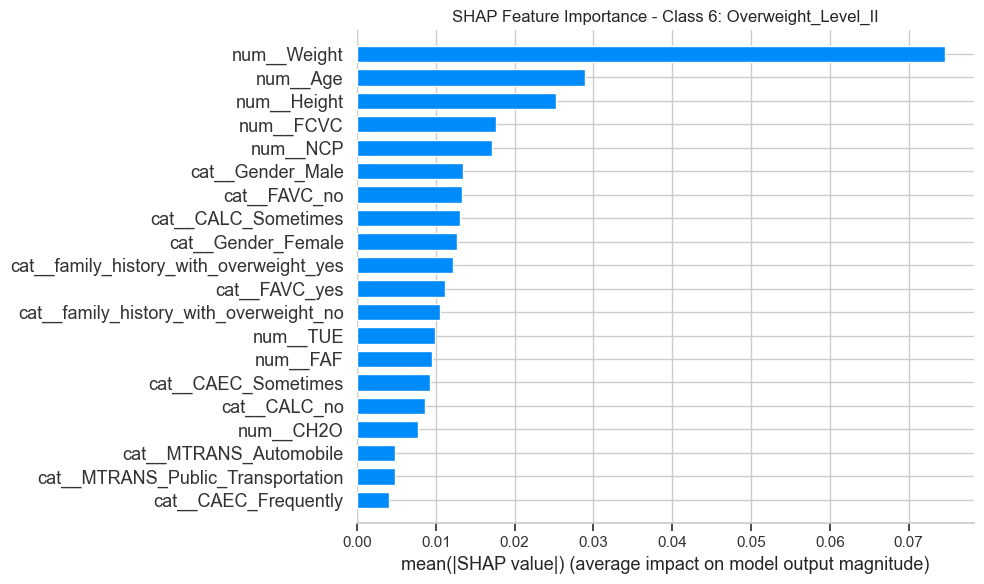

In [31]:
num_classes = len(np.unique(y_train))
class_names = label_encoder.inverse_transform(np.arange(num_classes))

# Create reproducible random generator
rng = np.random.default_rng(42)

# Loop over classes
for i in range(num_classes):
    class_label = class_names[i]
    print(f"Plotting SHAP for class {i}: {class_label}")
    class_shap = shap_values[:, :, i]

    # Bar Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        class_shap,
        X_preprocessed,
        feature_names=feature_names,
        plot_type="bar",
        show=False,
        plot_size=(10, 6),
        rng=rng  
    )
    plt.title(f"SHAP Feature Importance - Class {i}: {class_label}")
    plt.tight_layout()
    plt.savefig(f"../images/random_forest_shap_bar_class_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()

## 12. Conclusion

Random forest was trained using the obesity dataset. 

**Model Performance and Key Insights**
- The model was trained though hyperparameter tuning via GridSearchCV which gave an accuracy of about 93%.
    - The best parameters were:
        - classifier__class_weight: balanced
        - classifier__max_depth: 20 
        - classifier__max_features: sqrt 
        - classifier__min_samples_leaf: 1
        - classifier__min_samples_split: 2
        - classifier__n_estimators: 300
- The ROC-AUC curves show a strong discrimination across all the classes.
- Through SHAP analysis, we were able to identify which features are most predictive of which obesity class.
    - Class 0 - Insufficient Weight: weight, age, family history with overweight
    - Class 1 - Normal Weight: weight, CAEC_sometimes, age
    - Class 2 - Obesity Type I: weight, FCVC, height
    - Class 3 - Obesity_Type_II: weight, age, gender_male
    - Class 4 - Obesity_Type_III: weight, FCVC, gender_male
    - Class 5 - Overweight_Level_I: weight, age, FCVC
    - Class 6 - Overweight_Level_II: weight, age, height
